<a href="https://colab.research.google.com/github/zheken0ff/projectsds105/blob/main/RealGroup1Myshows1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PART 1 — Web Scraping (Dataset Creation)**

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import random
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
from IPython.display import display

# ================== НАСТРОЙКИ ==================
BASE_LIST_URL = "https://en.myshows.me/movies/catalog/?page={}"  # список фильмов
BASE_DOMAIN = "https://en.myshows.me"
TARGET_MOVIES = 10000        # сколько фильмов нужно (для теста можешь поставить 50/100)
MAX_PAGES = 400              # максимум страниц, чтобы найти 10k
HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/120.0.0.0 Safari/537.36"
    )
}

# ================== ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ ==================
def extract_field(pattern: str, text: str):
    """Ищет первое совпадение по regex и возвращает группу 1 или None."""
    m = re.search(pattern, text)
    return m.group(1).strip() if m else None


def parse_movie_page(movie_url: str) -> dict | None:
    """Парсит страницу фильма и вытаскивает нужные поля."""
    try:
        resp = requests.get(movie_url, headers=HEADERS, timeout=20)
        resp.raise_for_status()
    except Exception as e:
        print(f"  [!] Ошибка загрузки {movie_url}: {e}")
        return None

    soup = BeautifulSoup(resp.text, "html.parser")

    # Название
    title_tag = soup.find("h1")
    title = title_tag.get_text(strip=True) if title_tag else None

    # Весь текст страницы
    full_text = soup.get_text("\n", strip=True)

    # ----- Основные поля -----
    myshows_rating = extract_field(r"My Rating\s*([\d.]+)", full_text)
    country = extract_field(r"Country:\s*([^\n]+)", full_text)
    genres = extract_field(r"Genre:\s*([^\n]+)", full_text)
    imdb_rating = extract_field(r"IMDB Rating:\s*([\d.]+)", full_text)

    # год
    year = extract_field(r"(19\d{2}|20\d{2})", full_text)

    # длительность
    duration = extract_field(r"Runtime:\s*([^\n]+)", full_text)

    # производство (берём только первую компанию)
    production_full = extract_field(r"Production Companies:\s*([^\n]+)", full_text)
    if production_full:
        production = production_full.split(",")[0].strip()
    else:
        production = None

    # рейтинг кинопоиска
    kinopoisk_rating = extract_field(r"kinopoisk\.ru rating:\s*([\d.]+)", full_text)

    return {
        "url": movie_url,
        "title": title,
        "year": year,
        "country": country,
        "genre": genres,
        "myshows_rating": myshows_rating,
        "imdb_rating": imdb_rating,
        "duration": duration,
        "production": production,
        "kinopoisk_rating": kinopoisk_rating,
    }

# ================== ОСНОВНОЙ СКРАПИНГ ==================
all_movies = []
seen_urls = set()   # защита от дубликатов

for page_num in range(1, MAX_PAGES + 1):
    if len(all_movies) >= TARGET_MOVIES:
        break

    list_url = BASE_LIST_URL.format(page_num)
    print(f"\n=== Страница {page_num}: {list_url} ===")

    try:
        resp = requests.get(list_url, headers=HEADERS, timeout=20)
        resp.raise_for_status()
    except Exception as e:
        print(f"[!] Ошибка загрузки страницы {page_num}: {e}")
        continue

    soup = BeautifulSoup(resp.text, "html.parser")

    # Все ссылки вида /movie/XXXX/
    movie_links = soup.find_all(
        "a",
        href=lambda h: h and h.startswith("/movie/")
    )

    if not movie_links:
        print("  [!] Фильмов не найдено — структура изменилась.")
        continue

    print(f"  Найдено ссылок на фильмы: {len(movie_links)}")

    # --- собираем список уникальных URL для этой страницы ---
    urls_to_parse = []
    for a in movie_links:
        if len(all_movies) + len(urls_to_parse) >= TARGET_MOVIES:
            break

        href = a.get("href")
        if not href:
            continue

        movie_url = BASE_DOMAIN + href.split("?")[0]

        if movie_url in seen_urls:
            continue
        seen_urls.add(movie_url)
        urls_to_parse.append(movie_url)

    print(f"  Будет распарсено фильмов с этой страницы: {len(urls_to_parse)}")

    # --- парсим несколько фильмов ПАРАЛЛЕЛЬНО ---
    with ThreadPoolExecutor(max_workers=8) as executor:
        future_to_url = {executor.submit(parse_movie_page, url): url for url in urls_to_parse}

        for future in as_completed(future_to_url):
            movie_data = future.result()
            if movie_data:
                all_movies.append(movie_data)
                print(f"      Собрано фильмов: {len(all_movies)}")

    # пауза между страницами, чтобы не душить сайт
    time.sleep(random.uniform(1.0, 2.0))

print("\nSCRAPING DONE!")

# ================== DATAFRAME + СОХРАНЕНИЕ ==================
df_movies = pd.DataFrame(all_movies)
print(f"\nИтого фильмов ДО удаления дубликатов: {len(df_movies)}")

df_movies = df_movies.drop_duplicates(subset=["url"])
print(f"Итого фильмов ПОСЛЕ удаления дубликатов: {len(df_movies)}")

# порядок колонок
df_movies = df_movies[
    [
        "url",
        "title",
        "year",
        "country",
        "genre",
        "myshows_rating",
        "imdb_rating",
        "duration",
        "production",
        "kinopoisk_rating",
    ]
]

print("\n--- df_movies.head() ---")
display(df_movies.head())

print("\n--- df_movies.tail() ---")
display(df_movies.tail())

rows, cols = df_movies.shape
print(f"\nDataFrame shape: {rows} rows x {cols} columns")

output_filename = "myshows_movies_data.csv"
df_movies.to_csv(output_filename, index=False, encoding="utf-8-sig")

print(f"\nДатасет сохранён → {output_filename}")


Выходные данные были обрезаны до нескольких последних строк (5000).
      Собрано фильмов: 5320
      Собрано фильмов: 5321
      Собрано фильмов: 5322
      Собрано фильмов: 5323
      Собрано фильмов: 5324
      Собрано фильмов: 5325
      Собрано фильмов: 5326
      Собрано фильмов: 5327
      Собрано фильмов: 5328
      Собрано фильмов: 5329
      Собрано фильмов: 5330
      Собрано фильмов: 5331
      Собрано фильмов: 5332
      Собрано фильмов: 5333
      Собрано фильмов: 5334
      Собрано фильмов: 5335
      Собрано фильмов: 5336
      Собрано фильмов: 5337
      Собрано фильмов: 5338
      Собрано фильмов: 5339
      Собрано фильмов: 5340

=== Страница 90: https://en.myshows.me/movies/catalog/?page=90 ===
  Найдено ссылок на фильмы: 60
  Будет распарсено фильмов с этой страницы: 60
      Собрано фильмов: 5341
      Собрано фильмов: 5342
      Собрано фильмов: 5343
      Собрано фильмов: 5344
      Собрано фильмов: 5345
      Собрано фильмов: 5346
      Собрано фильмов: 5347
  

,url,title,year,country,genre,myshows_rating,imdb_rating,duration,production,kinopoisk_rating
0,https://en.myshows.me/movie/1118/,Fight Club,1999,Germany,Drama,4.58,8.8,2 hours 19 minutes,Fox 2000 Pictures,8.68
1,https://en.myshows.me/movie/78/,Avengers: Infinity War,2018,US,Adventure,4.52,8.4,2 hours 29 minutes,Marvel Studios,8.11
2,https://en.myshows.me/movie/598/,The Dark Knight,2008,UK,Drama,4.6,9.1,2 hours 32 minutes,Warner Bros. Pictures,8.53
3,https://en.myshows.me/movie/196/,Deadpool,2016,US,Action,4.36,8,1 hour 48 minutes,20th Century Fox,7.58
4,https://en.myshows.me/movie/121/,The Avengers,2012,US,Sci-Fi,4.47,8,2 hours 17 minutes,Marvel Studios,7.89



--- df_movies.tail() ---


,url,title,year,country,genre,myshows_rating,imdb_rating,duration,production,kinopoisk_rating
9995,https://en.myshows.me/movie/63093/,El Camino Christmas,2017,US,Comedy,0,5.7,1 hour 37 minutes,Goldenlight Films,None
9996,https://en.myshows.me/movie/70294/,You Can Count on Me,2000,US,Drama,0,7.5,1 hour 51 minutes,Crush Entertainment,6.81
9997,https://en.myshows.me/movie/67845/,Begotten,1991,US,Fantasy,0,5.6,1 hour 12 minutes,Theatre Of Material,None
9998,https://en.myshows.me/movie/32129/,Ratter,2015,US,Drama,0,4.8,1 hour 20 minutes,Start Motion Pictures,4.3
9999,https://en.myshows.me/movie/68123/,The Good German,2006,US,Drama,0,6,1 hour 48 minutes,Warner Bros. Pictures,None



DataFrame shape: 10000 rows x 10 columns

Датасет сохранён → myshows_movies_data.csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving myshows_movies_data.csv to myshows_movies_data (1).csv


In [ ]:
import pandas as pd
df = pd.read_csv("myshows_movies_data.csv")
df.head()

,url,title,year,country,genre,myshows_rating,imdb_rating,duration,production,kinopoisk_rating
0,https://en.myshows.me/movie/1118/,Fight Club,1999,Germany,Drama,4.58,8.8,2 hours 19 minutes,Fox 2000 Pictures,8.68
1,https://en.myshows.me/movie/78/,Avengers: Infinity War,2018,US,Adventure,4.52,8.4,2 hours 29 minutes,Marvel Studios,8.11
2,https://en.myshows.me/movie/598/,The Dark Knight,2008,UK,Drama,4.60,9.1,2 hours 32 minutes,Warner Bros. Pictures,8.53
3,https://en.myshows.me/movie/196/,Deadpool,2016,US,Action,4.36,8.0,1 hour 48 minutes,20th Century Fox,7.58
4,https://en.myshows.me/movie/121/,The Avengers,2012,US,Sci-Fi,4.47,8.0,2 hours 17 minutes,Marvel Studios,7.89


# **PART 2 — Data Cleaning & Preparation**

In [ ]:
import pandas as pd
from IPython.display import display

df = pd.read_csv("myshows_movies_data.csv")

print("First 5 rows of the DataFrame:")
display(df.head())


First 5 rows of the DataFrame:


,url,title,year,country,genre,myshows_rating,imdb_rating,duration,production,kinopoisk_rating
0,https://en.myshows.me/movie/1118/,Fight Club,1999,Germany,Drama,4.58,8.8,2 hours 19 minutes,Fox 2000 Pictures,8.68
1,https://en.myshows.me/movie/78/,Avengers: Infinity War,2018,US,Adventure,4.52,8.4,2 hours 29 minutes,Marvel Studios,8.11
2,https://en.myshows.me/movie/598/,The Dark Knight,2008,UK,Drama,4.60,9.1,2 hours 32 minutes,Warner Bros. Pictures,8.53
3,https://en.myshows.me/movie/196/,Deadpool,2016,US,Action,4.36,8.0,1 hour 48 minutes,20th Century Fox,7.58
4,https://en.myshows.me/movie/121/,The Avengers,2012,US,Sci-Fi,4.47,8.0,2 hours 17 minutes,Marvel Studios,7.89


In [ ]:
df.shape


(10000, 10)

In [ ]:
print(f"Row count: {df.shape[0]}")
print(f"Column count: {df.shape[1]}")

Row count: 10000
Column count: 10


# **WRONG TYPES**

In [ ]:
df.dtypes


,0
url,object
title,object
year,int64
country,object
genre,object
myshows_rating,float64
imdb_rating,float64
duration,object
production,object
kinopoisk_rating,float64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   url               10000 non-null  object 
 1   title             10000 non-null  object 
 2   year              10000 non-null  int64  
 3   country           9989 non-null   object 
 4   genre             9997 non-null   object 
 5   myshows_rating    10000 non-null  float64
 6   imdb_rating       9985 non-null   float64
 7   duration          9999 non-null   object 
 8   production        9968 non-null   object 
 9   kinopoisk_rating  6225 non-null   float64
dtypes: float64(3), int64(1), object(6)
memory usage: 781.4+ KB


In [ ]:
df.describe(include = 'all').T #можно df.describe().T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
url,10000,10000,https://en.myshows.me/movie/660350/,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title,10000,9619,Return,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,10000.0,NaN,NaN,NaN,2004.866,17.385525,1900.0,1998.0,2010.0,2017.0,2067.0
country,9989,78,US,5455,NaN,NaN,NaN,NaN,NaN,NaN,NaN
genre,9997,19,Drama,2138,NaN,NaN,NaN,NaN,NaN,NaN,NaN
myshows_rating,10000.0,NaN,NaN,NaN,2.60497,1.712232,0.0,0.0,3.48,3.85,4.77
imdb_rating,9985.0,NaN,NaN,NaN,6.528353,0.980872,1.7,5.9,6.6,7.2,9.3
duration,9999,204,1 hour 40 minutes,291,NaN,NaN,NaN,NaN,NaN,NaN,NaN
production,9968,3737,Paramount Pictures,274,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kinopoisk_rating,6225.0,NaN,NaN,NaN,6.839052,0.828511,1.65,6.3,6.89,7.42,9.11


# **MISSING VALUES**

In [ ]:
df.isnull().sum()

,0
url,0
title,0
year,0
country,11
genre,3
myshows_rating,0
imdb_rating,15
duration,1
production,32
kinopoisk_rating,3775


# **DUPLICATE**

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df = pd.read_csv("myshows_movies_data.csv")

In [ ]:
import re

def duration_to_minutes(text):
    if not isinstance(text, str):
        return None

    hours = 0
    minutes = 0

    # ищем часы
    h = re.search(r'(\d+)\s*hour', text)
    if h:
        hours = int(h.group(1))

    # ищем минуты
    m = re.search(r'(\d+)\s*minute', text)
    if m:
        minutes = int(m.group(1))

    return hours * 60 + minutes


In [ ]:
df['duration_minutes'] = df['duration'].apply(duration_to_minutes)
df = df.drop(columns=['duration'])


In [ ]:
df['country_main'] = df['country'].astype(str).apply(lambda x: x.split(',')[0].strip())
df['genre_main'] = df['genre'].astype(str).apply(lambda x: x.split(',')[0].strip())
df['production_main'] = df['production'].astype(str).apply(lambda x: x.split(',')[0].strip())

df = df.drop(columns=['country', 'genre', 'production'])

df.head()

,url,title,year,myshows_rating,imdb_rating,kinopoisk_rating,duration_minutes,country_main,genre_main,production_main
0,https://en.myshows.me/movie/1118/,Fight Club,1999,4.58,8.8,8.68,139.0,Germany,Drama,Fox 2000 Pictures
1,https://en.myshows.me/movie/78/,Avengers: Infinity War,2018,4.52,8.4,8.11,149.0,US,Adventure,Marvel Studios
2,https://en.myshows.me/movie/598/,The Dark Knight,2008,4.60,9.1,8.53,152.0,UK,Drama,Warner Bros. Pictures
3,https://en.myshows.me/movie/196/,Deadpool,2016,4.36,8.0,7.58,108.0,US,Action,20th Century Fox
4,https://en.myshows.me/movie/121/,The Avengers,2012,4.47,8.0,7.89,137.0,US,Sci-Fi,Marvel Studios


In [ ]:
df.dtypes

,0
url,object
title,object
year,int64
myshows_rating,float64
imdb_rating,float64
kinopoisk_rating,float64
duration_minutes,float64
country_main,object
genre_main,object
production_main,object


In [ ]:
print("\n--- First 5 rows ---")
display(df.head())

print("\n--- Last 5 rows ---")
display(df.tail())

rows, cols = df.shape
print(f"\nThe DataFrame has {rows} rows and {cols} columns.")

print("\n--- Info BEFORE cleaning ---")
print(df.info())

print("\n--- Describe BEFORE cleaning ---")
print(df.describe(include='all'))

print("\n--- Missing values BEFORE cleaning ---")
print(df.isnull().sum())

print("\n--- Full duplicates BEFORE (all columns) ---")
print(df.duplicated().sum())


--- First 5 rows ---


,url,title,year,myshows_rating,imdb_rating,kinopoisk_rating,duration_minutes,country_main,genre_main,production_main
0,https://en.myshows.me/movie/1118/,Fight Club,1999,4.58,8.8,8.68,139.0,Germany,Drama,Fox 2000 Pictures
1,https://en.myshows.me/movie/78/,Avengers: Infinity War,2018,4.52,8.4,8.11,149.0,US,Adventure,Marvel Studios
2,https://en.myshows.me/movie/598/,The Dark Knight,2008,4.60,9.1,8.53,152.0,UK,Drama,Warner Bros. Pictures
3,https://en.myshows.me/movie/196/,Deadpool,2016,4.36,8.0,7.58,108.0,US,Action,20th Century Fox
4,https://en.myshows.me/movie/121/,The Avengers,2012,4.47,8.0,7.89,137.0,US,Sci-Fi,Marvel Studios



--- Last 5 rows ---


,url,title,year,myshows_rating,imdb_rating,kinopoisk_rating,duration_minutes,country_main,genre_main,production_main
9995,https://en.myshows.me/movie/63093/,El Camino Christmas,2017,0.0,5.7,NaN,97.0,US,Comedy,Goldenlight Films
9996,https://en.myshows.me/movie/70294/,You Can Count on Me,2000,0.0,7.5,6.81,111.0,US,Drama,Crush Entertainment
9997,https://en.myshows.me/movie/67845/,Begotten,1991,0.0,5.6,NaN,72.0,US,Fantasy,Theatre Of Material
9998,https://en.myshows.me/movie/32129/,Ratter,2015,0.0,4.8,4.30,80.0,US,Drama,Start Motion Pictures
9999,https://en.myshows.me/movie/68123/,The Good German,2006,0.0,6.0,NaN,108.0,US,Drama,Warner Bros. Pictures



The DataFrame has 10000 rows and 10 columns.

--- Info BEFORE cleaning ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   url               10000 non-null  object 
 1   title             10000 non-null  object 
 2   year              10000 non-null  int64  
 3   myshows_rating    10000 non-null  float64
 4   imdb_rating       9985 non-null   float64
 5   kinopoisk_rating  6225 non-null   float64
 6   duration_minutes  9999 non-null   float64
 7   country_main      10000 non-null  object 
 8   genre_main        10000 non-null  object 
 9   production_main   10000 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 781.4+ KB
None

--- Describe BEFORE cleaning ---
                                        url   title          year  \
count                                 10000   10000  10000.000000   
unique     

In [ ]:
import numpy as np

df = df.replace('N/A', np.nan)
df = df.replace('', np.nan)

print("\n--- Missing values AFTER replacing 'N/A' and '' ---")
print(df.isnull().sum())



--- Missing values AFTER replacing 'N/A' and '' ---
url                    0
title                  0
year                   0
myshows_rating         0
imdb_rating           15
kinopoisk_rating    3775
duration_minutes       1
country_main           0
genre_main             0
production_main        0
dtype: int64


In [ ]:
# Список текстовых колонок, которые хотим просто подчистить от пробелов
text_cols = [
    'url',
    'title',
    'country',
    'genre',
    'production',
    'country_main',
    'genre_main',
    'production_main'
]

for col in text_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# Приводим жанр и страну к нижнему регистру (по желанию, для более аккуратных группировок)
if 'country_main' in df.columns:
    df['country_main'] = df['country_main'].str.lower()

if 'genre_main' in df.columns:
    df['genre_main'] = df['genre_main'].str.lower()

if 'production_main' in df.columns:
    df['production_main'] = df['production_main'].str.strip()

print("\n--- Missing values AFTER text cleaning ---")
print(df.isnull().sum())



--- Missing values AFTER text cleaning ---
url                    0
title                  0
year                   0
myshows_rating         0
imdb_rating           15
kinopoisk_rating    3775
duration_minutes       1
country_main           0
genre_main             0
production_main        0
dtype: int64


In [ ]:
print("\n--- Missing values BEFORE dropping/filling ---")
print(df.isnull().sum())

# 1️⃣ Удаляем строки, где нет title (фильм без названия бесполезен)
df = df.dropna(subset=['title'])

# 2️⃣ Заполняем числовые колонки медианой
numeric_cols = ['year', 'myshows_rating', 'imdb_rating', 'kinopoisk_rating']

for col in numeric_cols:
    if col in df.columns:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)

# 3️⃣ Заполняем текстовые колонки значением "unknown"
text_cols = ['country', 'genre', 'production',
             'country_main', 'genre_main', 'production_main']

for col in text_cols:
    if col in df.columns:
        df[col] = df[col].fillna("unknown")

print("\n--- Missing values AFTER filling ---")
print(df.isnull().sum())



--- Missing values BEFORE dropping/filling ---
url                    0
title                  0
year                   0
myshows_rating         0
imdb_rating           15
kinopoisk_rating    3775
duration_minutes       1
country_main           0
genre_main             0
production_main        0
dtype: int64

--- Missing values AFTER filling ---
url                 0
title               0
year                0
myshows_rating      0
imdb_rating         0
kinopoisk_rating    0
duration_minutes    1
country_main        0
genre_main          0
production_main     0
dtype: int64


In [ ]:
print("\n--- Duplicates by ['title', 'year'] BEFORE ---")
print(df.duplicated(subset=['title', 'year']).sum())

# удаляем полные дубли по (title, year)
df = df.drop_duplicates(subset=['title', 'year'])

print("\n--- Duplicates by ['title', 'year'] AFTER ---")
print(df.duplicated(subset=['title', 'year']).sum())



--- Duplicates by ['title', 'year'] BEFORE ---
8

--- Duplicates by ['title', 'year'] AFTER ---
0


# **REMOVE OUTLIERS**

In [ ]:
def remove_outliers_iqr(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR

    before = len(dataframe)
    dataframe = dataframe[(dataframe[column] >= low) & (dataframe[column] <= high)]
    after = len(dataframe)

    print(f"{column}: removed {before - after} outliers")
    return dataframe


# применяем к числовым колонкам myshows
numeric_cols = ['year', 'myshows_rating', 'imdb_rating', 'kinopoisk_rating', 'duration_minutes']

for col in numeric_cols:
    if col in df.columns:
        df = remove_outliers_iqr(df, col)


year: removed 535 outliers
myshows_rating: removed 0 outliers
imdb_rating: removed 141 outliers
kinopoisk_rating: removed 1972 outliers
duration_minutes: removed 313 outliers


In [ ]:
current_year = 2025

# возраст фильма
df['movie_age'] = current_year - df['year']

# десятилетие (2000, 2010, 2020...)
df['decade'] = (df['year'] // 10) * 10

# разница между рейтингами IMDb и MyShows
df['rating_gap_imdb_myshows'] = df['imdb_rating'] - df['myshows_rating']

# разница IMDb и Kinopoisk
df['rating_gap_imdb_kp'] = df['imdb_rating'] - df['kinopoisk_rating']

# длина фильма в часах (для графиков)
df['duration_hours'] = df['duration_minutes'] / 60

# компактная сложность студии (сколько фильмов у этой студии)
df['studio_movie_count'] = df.groupby('production_main')['production_main'].transform('count')

print("\n--- INFO AFTER FULL CLEANING ---")
print(df.info())

print("\n--- DESCRIBE AFTER FULL CLEANING (categorical-style) ---")
display(df.describe(include='all').T[['count', 'unique', 'top', 'freq']])


--- INFO AFTER FULL CLEANING ---
<class 'pandas.core.frame.DataFrame'>
Index: 7031 entries, 3 to 9999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   url                      7031 non-null   object 
 1   title                    7031 non-null   object 
 2   year                     7031 non-null   int64  
 3   myshows_rating           7031 non-null   float64
 4   imdb_rating              7031 non-null   float64
 5   kinopoisk_rating         7031 non-null   float64
 6   duration_minutes         7031 non-null   float64
 7   country_main             7031 non-null   object 
 8   genre_main               7031 non-null   object 
 9   production_main          7031 non-null   object 
 10  movie_age                7031 non-null   int64  
 11  decade                   7031 non-null   int64  
 12  rating_gap_imdb_myshows  7031 non-null   float64
 13  rating_gap_imdb_kp       7031 non-null   float64


,count,unique,top,freq
url,7031,7031,https://en.myshows.me/movie/68123/,1
title,7031,6882,The Killer,4
year,7031.0,NaN,NaN,NaN
myshows_rating,7031.0,NaN,NaN,NaN
imdb_rating,7031.0,NaN,NaN,NaN
kinopoisk_rating,7031.0,NaN,NaN,NaN
duration_minutes,7031.0,NaN,NaN,NaN
country_main,7031,66,us,3840
genre_main,7031,19,comedy,1500
production_main,7031,2874,Paramount Pictures,192


In [ ]:
df.to_csv('myshows_cleaned.csv', index=False, encoding='utf-8-sig')
print("\nCleaned data saved to 'myshows_cleaned.csv'")



Cleaned data saved to 'myshows_cleaned.csv'


# **PART 3 — Exploratory Data Analysis (EDA)**

#**DESCRIPTIVE STATISTICS**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
numeric_cols = [
    'year',
    'myshows_rating',
    'imdb_rating',
    'kinopoisk_rating',
    'duration_minutes',
    'movie_age',
    'decade',
    'rating_gap_imdb_myshows',
    'rating_gap_imdb_kp',
    'duration_hours',
    'studio_movie_count'
]

print("\n--- Descriptive statistics (numeric columns) ---")
print(df[numeric_cols].describe())



--- Descriptive statistics (numeric columns) ---
              year  myshows_rating  imdb_rating  kinopoisk_rating  \
count  7031.000000     7031.000000  7031.000000       7031.000000   
mean   2007.559664        2.597697     6.499061          6.885217   
std      12.660558        1.694560     0.771733          0.307289   
min    1970.000000        0.000000     4.000000          6.110000   
25%    2000.500000        0.000000     6.000000          6.840000   
50%    2010.000000        3.510000     6.500000          6.890000   
75%    2018.000000        3.800000     7.100000          6.910000   
max    2025.000000        4.610000     8.900000          7.660000   

       duration_minutes    movie_age       decade  rating_gap_imdb_myshows  \
count       7031.000000  7031.000000  7031.000000              7031.000000   
mean         105.524250    17.440336  2003.129000                 3.901364   
std           15.384404    12.660558    12.972024                 1.861768   
min           61

# **VISUALIZATIONS**

**1. Distribution of movie release year**

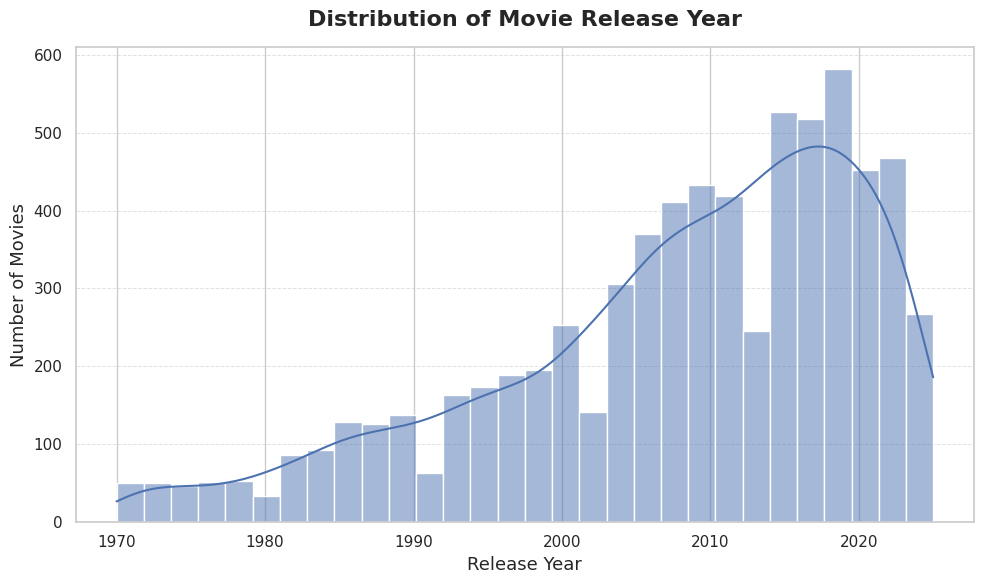

In [ ]:
plt.figure(figsize=(10,6))

sns.histplot(
    df['year'],
    bins=30,
    kde=True,
    color="#4C72B0",        # мягкий синий цвет
    edgecolor="white",      # белые границы столбцов
    linewidth=1
    )
plt.title(
    "Distribution of Movie Release Year",
    fontsize=16,
    fontweight="bold",
    pad=15
)

plt.xlabel("Release Year", fontsize=13)
plt.ylabel("Number of Movies", fontsize=13)

plt.grid(
    axis='y',
    linestyle='--',
    linewidth=0.7,
    alpha=0.6
)
plt.tight_layout()
plt.show()


**2. Distribution of movie duration (minutes)**

/tmp/ipython-input-310545098.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


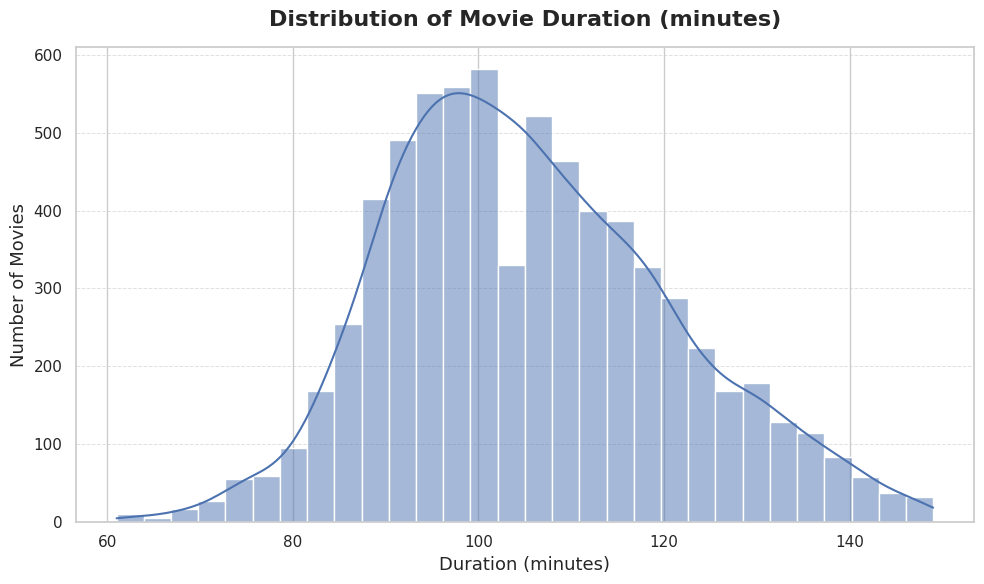

In [ ]:
plt.figure(figsize=(10,6))

sns.histplot(
    df['duration_minutes'],
    bins=30,
    kde=True,
    palette="viridis",   # яркая разноцветная палитра
    edgecolor="white",
    linewidth=1,
    color=None,          # отключаем фиксированный цвет, даём палитре работать
)

plt.title(
    "Distribution of Movie Duration (minutes)",
    fontsize=16,
    fontweight="bold",
    pad=15
)

plt.xlabel("Duration (minutes)", fontsize=13)
plt.ylabel("Number of Movies", fontsize=13)

plt.grid(
    axis='y',
    linestyle='--',
    linewidth=0.7,
    alpha=0.6
)

plt.tight_layout()
plt.show()


**3. Distribution of IMDb rating**

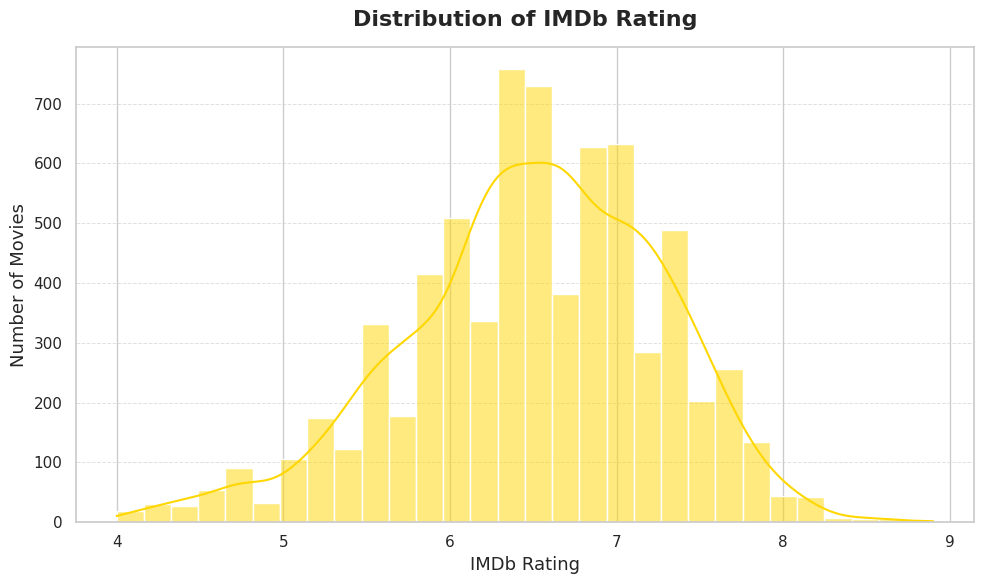

In [ ]:
plt.figure(figsize=(10,6))

sns.histplot(
    df['imdb_rating'],
    bins=30,
    kde=True,
    color="#FFD700",       # ЗОЛОТО-ЖЁЛТЫЙ цвет
    edgecolor="white",
    linewidth=1,
)

plt.title(
    "Distribution of IMDb Rating",
    fontsize=16,
    fontweight="bold",
    pad=15
)

plt.xlabel("IMDb Rating", fontsize=13)
plt.ylabel("Number of Movies", fontsize=13)

plt.grid(
    axis='y',
    linestyle='--',
    linewidth=0.7,
    alpha=0.6
)

plt.tight_layout()
plt.show()


**4. Top 10 production companies by number of movie**

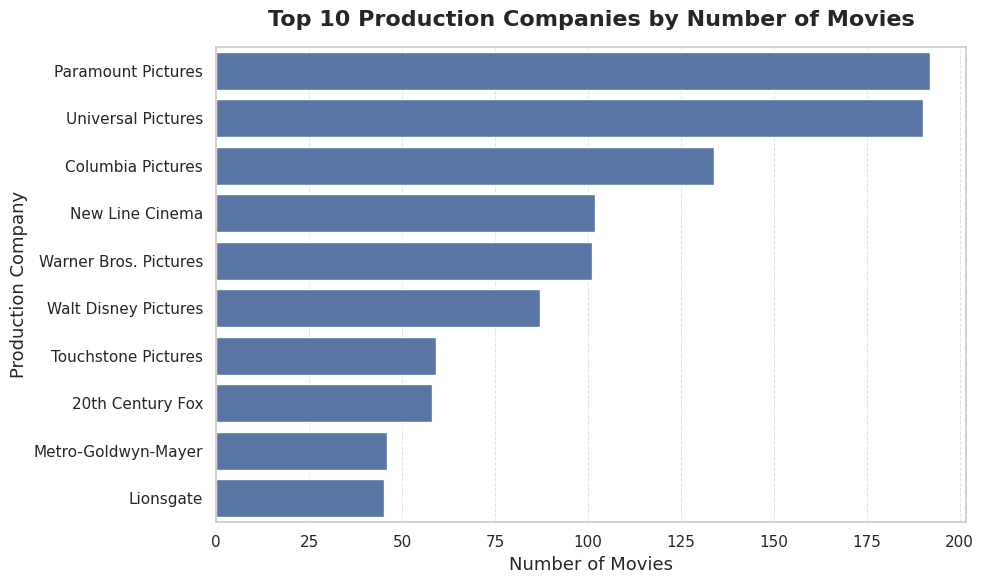

In [ ]:
top_productions = df['production_main'].value_counts().head(10)

plt.figure(figsize=(10,6))

sns.barplot(
    x=top_productions.values,
    y=top_productions.index,
    color="#4C72B0"      # красивый синий цвет
)

plt.title(
    "Top 10 Production Companies by Number of Movies",
    fontsize=16,
    fontweight="bold",
    pad=15
)

plt.xlabel("Number of Movies", fontsize=13)
plt.ylabel("Production Company", fontsize=13)

plt.grid(
    axis='x',
    linestyle='--',
    linewidth=0.7,
    alpha=0.6
)

plt.tight_layout()
plt.show()


**5. Number of movies by decade**

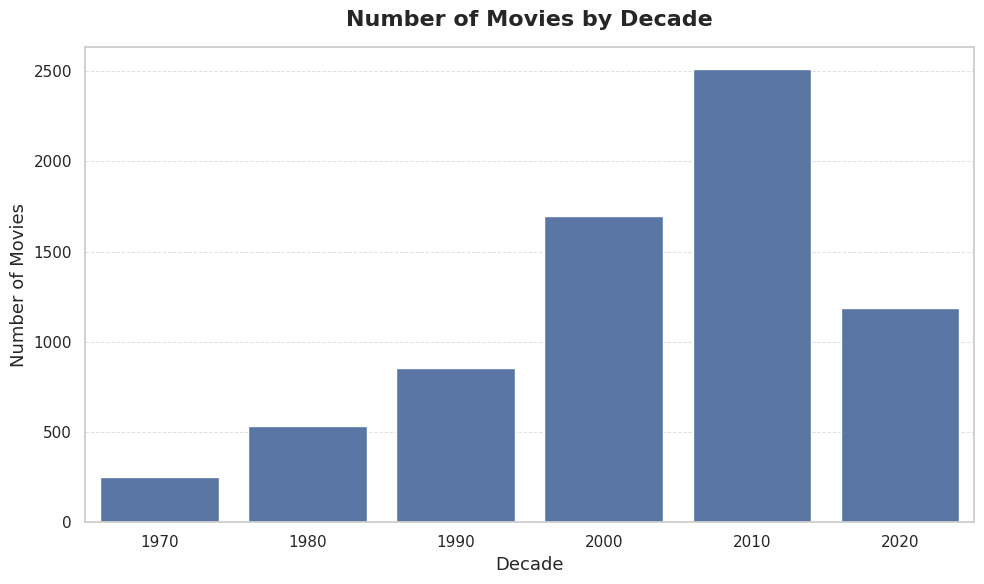

In [ ]:
movies_by_decade = df['decade'].value_counts().sort_index()

plt.figure(figsize=(10,6))

sns.barplot(
    x=movies_by_decade.index.astype(int),
    y=movies_by_decade.values,
    color="#4C72B0"    # красивый синий цвет
)

plt.title(
    "Number of Movies by Decade",
    fontsize=16,
    fontweight="bold",
    pad=15
)

plt.xlabel("Decade", fontsize=13)
plt.ylabel("Number of Movies", fontsize=13)

plt.grid(
    axis='y',
    linestyle='--',
    linewidth=0.7,
    alpha=0.6
)

plt.tight_layout()
plt.show()


**6. Top 10 Genres by Number of Movies**

/tmp/ipython-input-3587004001.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.values, y=top_genres.index, palette="viridis")


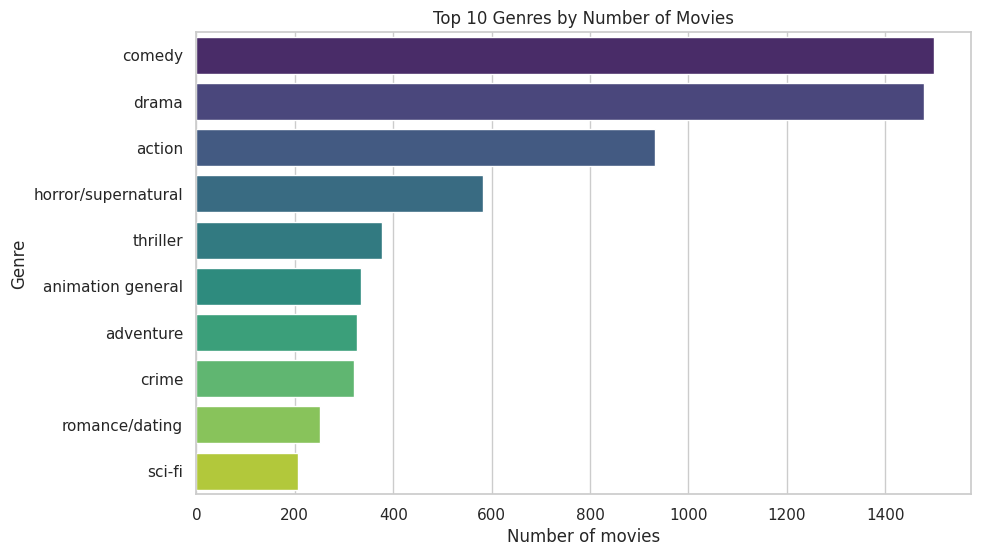

In [ ]:
top_genres = df['genre_main'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_genres.values, y=top_genres.index, palette="viridis")
plt.title("Top 10 Genres by Number of Movies")
plt.xlabel("Number of movies")
plt.ylabel("Genre")
plt.show()


**7. Relationship between movie duration and IMDb rating**

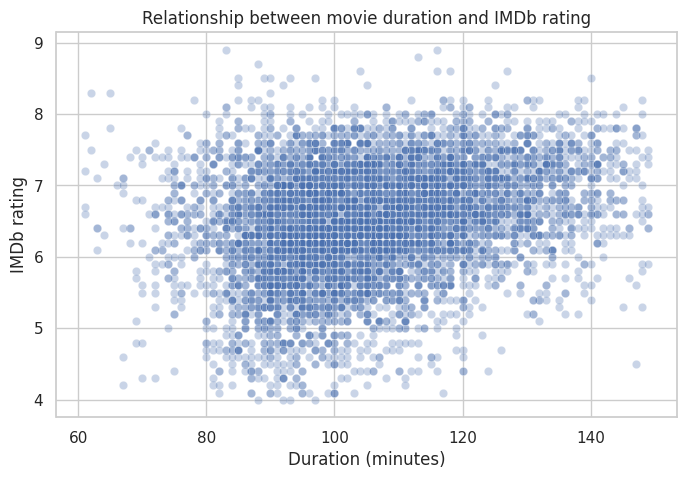

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='duration_minutes', y='imdb_rating', alpha=0.3)
plt.title("Relationship between movie duration and IMDb rating")
plt.xlabel("Duration (minutes)")
plt.ylabel("IMDb rating")
plt.show()


# **ANALYTICAL QUESTIONS:**

**QUESTION 1: Top 5 longest movies by duration:**

In [ ]:
print("\nQ1: Top 5 longest movies by duration:")
display(
    df[['title', 'production_main', 'duration_minutes']]
    .sort_values('duration_minutes', ascending=False)
    .head(5)
)

print("\nQ1: Top 5 shortest movies by duration:")
display(
    df[['title', 'production_main', 'duration_minutes']]
    .sort_values('duration_minutes', ascending=True)
    .head(5)
)



Q1: Top 5 longest movies by duration:


,title,production_main,duration_minutes
1328,Lincoln,DreamWorks Pictures,149.0
1120,Furiosa: A Mad Max Saga,Warner Bros. Pictures,149.0
3708,The School for Good and Evil,Feigco Entertainment,149.0
7315,Lost Illusions,Curiosa Films,149.0
373,The Da Vinci Code,Imagine Entertainment,149.0



Q1: Top 5 shortest movies by duration:


,title,production_main,duration_minutes
6648,Dragon Ball Z: The Tree of Might,Toei Animation,61.0
8539,Dou kyu sei – Classmates,A-1 Pictures,61.0
4263,"Miraculous World: New York, United HeroeZ",ZAG Entertainment,61.0
6999,Return,nan,61.0
9489,It's Such a Beautiful Day,Bitter Films,62.0


**QUESTION 2: Which genres have the highest average IMDb rating?**

In [ ]:
q2_result = (
    df.groupby('genre_main')['imdb_rating']
      .mean()
      .sort_values(ascending=False)
      .reset_index()
      .rename(columns={'imdb_rating': 'avg_imdb_rating'}))
display(q2_result)


,genre_main,avg_imdb_rating
0,documentary,7.548101
1,history,6.945714
2,western,6.945455
3,military/war,6.926786
4,drama,6.858254
5,crime,6.744688
6,cinema/theatre,6.716667
7,animation general,6.700597
8,music,6.682143
9,adventure,6.488379


**QUESTION 3: Which genres have the longest movies on average?**

In [ ]:
q3_result = (
    df.groupby('genre_main')['duration_minutes']
      .mean()
      .sort_values(ascending=False)
      .reset_index()
      .rename(columns={'duration_minutes': 'avg_duration_minutes'}))
display(q3_result)


,genre_main,avg_duration_minutes
0,history,121.085714
1,military/war,116.714286
2,western,115.454545
3,drama,111.836942
4,crime,110.668750
5,adventure,109.422018
6,action,109.104077
7,music,107.482143
8,sci-fi,107.092233
9,mystery,107.053763


**QUESTION 4: Which countries produce the highest-rated movies (by IMDb)?**


In [ ]:
q4_result = (
    df.groupby('country_main')['imdb_rating']
      .mean()
      .sort_values(ascending=False)
      .reset_index()
      .rename(columns={'imdb_rating': 'avg_imdb_rating'}))
display(q4_result.head(20))


,country_main,avg_imdb_rating
0,the faroe islands,8.100000
1,latvia,7.900000
2,iran,7.871429
3,turkey,7.675000
4,malawi,7.600000
5,czechoslovakia,7.600000
6,ecuador,7.400000
7,estonia,7.200000
8,austria,7.123077
9,denmark,7.119149


**QUESTION 5: Which production studios create the highest-rated movies?**

In [ ]:
# Можно добавить фильтр: только студии с >= 5 фильмами
studio_counts = df['production_main'].value_counts()
valid_studios = studio_counts[studio_counts >= 5].index

q5_result = (
    df[df['production_main'].isin(valid_studios)]
      .groupby('production_main')['imdb_rating']
      .mean()
      .sort_values(ascending=False)
      .reset_index()
      .rename(columns={'imdb_rating': 'avg_imdb_rating'}))
display(q5_result.head(20))  # топ-20 студий


,production_main,avg_imdb_rating
0,CiBy 2000,7.680000
1,Madhouse,7.666667
2,CJ Entertainment,7.450000
3,Sixteen Films,7.400000
4,HBO Films,7.357143
5,Goldcrest,7.340000
6,Next Entertainment World,7.320000
7,Bandai Visual,7.300000
8,A-1 Pictures,7.240000
9,TOHO,7.222222


**QUESTION 6: Is there a relationship between the number of movies in a genre and their average quality?**

In [ ]:
genre_counts = df['genre_main'].value_counts().rename('movie_count')
genre_avg_rating = df.groupby('genre_main')['imdb_rating'].mean().rename('avg_imdb_rating')

q6_result = (
    pd.concat([genre_counts, genre_avg_rating], axis=1)
      .reset_index()
      .rename(columns={'index': 'genre_main'})
      .sort_values('movie_count', ascending=False))
display(q6_result)


,genre_main,movie_count,avg_imdb_rating
0,comedy,1500,6.365933
1,drama,1478,6.858254
2,action,932,6.365129
3,horror/supernatural,583,6.062093
4,thriller,378,6.361905
5,animation general,335,6.700597
6,adventure,327,6.488379
7,crime,320,6.744688
8,romance/dating,252,6.283333
9,sci-fi,206,6.360680


**QUESTION 7: Which genres age better (old vs new movies)?**

In [ ]:
def old_new_stats(group):
    old = group[group['year'] <= 2000]['imdb_rating'].mean()
    new = group[group['year'] > 2000]['imdb_rating'].mean()
    return pd.Series({
        'avg_old_rating': old,
        'avg_new_rating': new,
        'diff_old_minus_new': (old - new) if pd.notnull(old) and pd.notnull(new) else None})
q7_result = (
    df.groupby('genre_main')
      .apply(old_new_stats)
      .dropna(subset=['diff_old_minus_new'])
      .sort_values('diff_old_minus_new', ascending=False)
      .reset_index())
display(q7_result)

/tmp/ipython-input-2903851971.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(old_new_stats)


,genre_main,avg_old_rating,avg_new_rating,diff_old_minus_new
0,documentary,8.142857,7.490278,0.652579
1,mystery,6.940909,6.302817,0.638092
2,fantasy,6.695122,6.181513,0.513609
3,crime,7.033010,6.607834,0.425176
4,comedy,6.650111,6.244529,0.405582
5,thriller,6.661842,6.286424,0.375418
6,music,6.966667,6.604545,0.362121
7,western,7.117647,6.762500,0.355147
8,horror/supernatural,6.271910,5.969877,0.302034
9,drama,7.044056,6.813674,0.230381


**QUESTION 8: How did the average movie rating change across decades?**

In [ ]:
q8_result = (
    df.groupby('decade')['imdb_rating']
      .mean()
      .sort_values()
      .reset_index()
      .rename(columns={'imdb_rating': 'avg_rating'}))
display(q8_result)


,decade,avg_rating
0,2020,6.328752
1,2000,6.413687
2,1990,6.515592
3,2010,6.525349
4,1980,6.722948
5,1970,7.080952
